In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from zipfile import ZipFile
import math

In [7]:
#https://dev.binance.vision/t/aggtrades-retrieving-data-over-a-date-range/14050/10
df = pd.read_csv(ZipFile("../data/spot/daily/aggTrades/BTCUSDT/BTCUSDT-aggTrades-2023-07-01.zip").open("BTCUSDT-aggTrades-2023-07-01.csv"), names=["aggregated_id","price","quantity","first_trade_id","last_trade_id","last_timestamp","is_buyer_maker","is_best_match"])    

In [8]:
df.head()

,aggregated_id,price,quantity,first_trade_id,last_trade_id,last_timestamp,is_buyer_maker,is_best_match
0,2665113116,30471.99,0.00091,3160456170,3160456170,1688169600000,True,True
1,2665113117,30471.99,0.00194,3160456171,3160456171,1688169600000,True,True
2,2665113118,30472.00,0.00213,3160456172,3160456172,1688169600001,False,True
3,2665113119,30471.99,0.00104,3160456173,3160456173,1688169600002,True,True
4,2665113120,30472.00,0.00065,3160456174,3160456174,1688169600006,False,True


https://github.com/binance/binance-spot-api-docs/blob/master/faqs/market_data_only.md

Describing the method for value area

https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781118659724.app1

In [9]:
def create_volume_profile_ticks(data, num_bins=0):
    # Calculate the price range for binning
    min_price = data['price'].min()
    max_price = data['price'].max()
    price_range = max_price - min_price
    
    #calculate bin size if not provided
    if num_bins != 0:
        bin_size= int(price_range/num_bins)
        
    # calculate the number of bins dinamically if not provided
    if num_bins == 0:
        #use two times the natural log of the price range to calculate the bin size
        bin_size = 2*round(math.log(price_range),0)
        num_bins = int(price_range/bin_size)

    # Create the bins
    bins = [min_price + i * bin_size for i in range(num_bins + 1)]

    # Bin the data and calculate total volume for each bin
    volume_profile = []
    for i in range(num_bins):
        bin_data = data[(data['price'] >= bins[i]) & (data['price'] < bins[i+1])]
        total_volume = bin_data['quantity'].sum()      
        volume_profile.append(total_volume)

    return bins[:-1], volume_profile

def plot_volume_profile(bins, volume_profile, value_area_low, value_area_high, point_of_control):
    colors = ['#EC6477' if bins[i] == point_of_control else ('#638DA8' if value_area_low <= bins[i] <= value_area_high else '#638DA880') for i in range(len(bins))]
    fig,ax = plt.subplots(figsize=(4,8))
    plt.barh(bins, volume_profile, height=(bins[1]-bins[0]), align='edge', ec='#2A2D3D', color=colors)
    #interior plot color
    ax.set_facecolor('#2A2D3D')
    #exterior plot color
    fig.set_facecolor('#2A2D3D')
    ax.spines['bottom'].set_color('#FFFFFF')
    ax.spines['top'].set_color('#FFFFFF00')
    ax.spines['left'].set_color('#FFFFFF')
    ax.spines['right'].set_color('#FFFFFF00')
    ax.xaxis.label.set_color('#FFFFFF')
    ax.yaxis.label.set_color('#FFFFFF')
    ax.tick_params(axis='x', colors='#FFFFFF')
    ax.tick_params(axis='y', colors='#FFFFFF')
    plt.xlabel('volume')
    plt.ylabel('price')
    plt.show()

def calculate_point_of_control(bins, volume_profile):
    poc_index = np.argmax(volume_profile)
    point_of_control = bins[poc_index]
    
    return point_of_control

def calculate_value_area_with_highest_dual_bins(bins, volume_profile, percentage):
    # Find the index of the bin with the greatest volume
    highest_volume_index = volume_profile.index(max(volume_profile))

    # Initialize variables to track the value area
    value_area_low = min(bins)
    value_area_high = max(bins)
    value_area_volume = volume_profile[highest_volume_index]
    high_index = 0
    low_index = 0

    # Calculate the total volume
    total_volume = sum(volume_profile)

    # Calculate the target volume for the Value Area (68% of the total volume)
    target_volume = total_volume * percentage / 100

    # Loop until the value area reaches 68% of the total volume or no more bins to check
    while value_area_volume <= target_volume:
        # Calculate the total volume of the dual bins above and below
        if highest_volume_index + 2 + high_index < len(bins):
            dual_bins_volume_above = volume_profile[highest_volume_index + 1 +
                                                    high_index] + volume_profile[highest_volume_index + 2 + high_index]
            dual_bins_volume_below = volume_profile[highest_volume_index - 1 -
                                                    low_index] + volume_profile[highest_volume_index - 2 - low_index]

            # Compare the dual bins volume and update the value area if needed
            if dual_bins_volume_above >= dual_bins_volume_below or highest_volume_index - 2 - low_index < 0:
                value_area_volume += dual_bins_volume_above
                value_area_high = bins[highest_volume_index + 2 + high_index]
                high_index += 2
            elif dual_bins_volume_above < dual_bins_volume_below or highest_volume_index + 2 + high_index >= len(bins):
                value_area_volume += dual_bins_volume_below
                value_area_low = bins[highest_volume_index - 2 - low_index]
                low_index += 2
        else:
            dual_bins_volume_below = volume_profile[highest_volume_index - 1 -
                                                    low_index] + volume_profile[highest_volume_index - 2 - low_index]
            value_area_volume += dual_bins_volume_below
            value_area_low = bins[highest_volume_index - 2 - low_index]
            low_index += 2

    return value_area_low, value_area_high

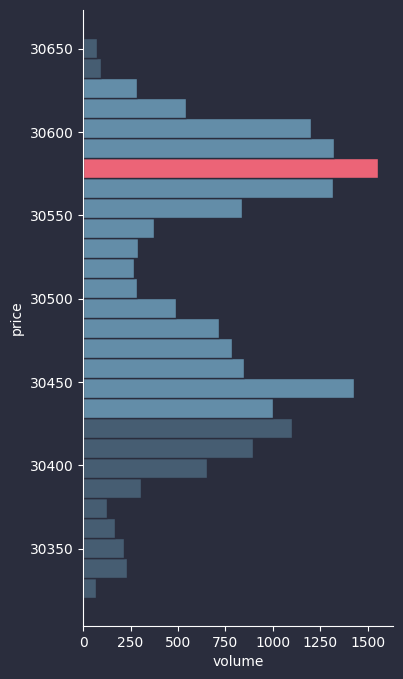

PoC Price: 30572.57
Value Area (68%): 30428.57 to 30620.57


In [10]:
# Number of bins for the volume profile
num_bins = 50
# Create volume profile
bins, volume_profile = create_volume_profile_ticks(df.copy(), num_bins)

# Calculate the Value Area (using the function with dual bins)
percentage = 68
value_area_low, value_area_high = calculate_value_area_with_highest_dual_bins(bins, volume_profile, percentage)

# Plot volume profile with Value Area and PoC
plot_volume_profile(bins, volume_profile, value_area_low, value_area_high, calculate_point_of_control(bins, volume_profile))

print(f"PoC Price: {round(calculate_point_of_control(bins, volume_profile), 2)}")
print(f"Value Area (68%): {round(value_area_low, 2)} to {round(value_area_high, 2)}")
